In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import pandas as pd
import collections
from torch.utils.data import Dataset
from tqdm import tqdm


In [3]:
class ColorTypeDataset(Dataset):
    def __init__(self, path, label_map, transform=None):
        self.samples = []
        self.label_map = label_map
        self.transform = transform

        for label_name, label_id in label_map.items():
            folder = os.path.join(path, label_name)
            if not os.path.isdir(folder):
                continue
            for filename in os.listdir(folder):
                if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.samples.append((os.path.join(folder, filename), label_id))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


In [4]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

label_map = {
    'autumn': 0,
    'spring': 1,
    'summer': 2,
    'winter': 3
}

In [14]:
batch_size = 16 

In [15]:
train_dataset = ColorTypeDataset('faces_cleaned_only_augmentated/', label_map, transform=train_transform)
val_dataset = ColorTypeDataset('colortypes_cleaned_back/', label_map, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [19]:
IMG_SIZE = 128
num_classes = 4
epochs = 40
patience = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
model = resnet.to(device)

# === Loss, optimizer, scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

# === Training loop with early stopping ===
best_val_loss = 10**10
early_stop_counter = 0

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in tqdm(train_loader):
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # === Validation phase ===
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

            pred_labels = preds.argmax(dim=1)
            val_correct += (pred_labels == yb).sum().item()
            val_total += len(xb)

    val_accuracy = val_correct / val_total * 100
    scheduler.step(val_accuracy)

    print(f"Epoch {epoch+1}: Val Accuracy = {val_accuracy:.2f}%, Train Loss = {total_loss:.4f}, LR = {optimizer.param_groups[0]['lr']:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pt")
        print("Validation loss improved. Model saved.")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break


100%|██████████| 240/240 [00:10<00:00, 22.47it/s]


Epoch 1: Val Accuracy = 36.36%, Train Loss = 240.2181, LR = 0.000500
Validation loss improved. Model saved.


100%|██████████| 240/240 [00:10<00:00, 22.32it/s]


Epoch 2: Val Accuracy = 45.45%, Train Loss = 167.9090, LR = 0.000500
Validation loss improved. Model saved.


100%|██████████| 240/240 [00:10<00:00, 22.92it/s]


Epoch 3: Val Accuracy = 40.36%, Train Loss = 115.9684, LR = 0.000500


100%|██████████| 240/240 [00:11<00:00, 21.63it/s]


Epoch 4: Val Accuracy = 41.82%, Train Loss = 77.2805, LR = 0.000500


100%|██████████| 240/240 [00:10<00:00, 23.18it/s]


Epoch 5: Val Accuracy = 45.45%, Train Loss = 68.4579, LR = 0.000500


100%|██████████| 240/240 [00:11<00:00, 21.62it/s]


Epoch 6: Val Accuracy = 46.55%, Train Loss = 60.8500, LR = 0.000500


100%|██████████| 240/240 [00:10<00:00, 22.78it/s]


Epoch 7: Val Accuracy = 45.45%, Train Loss = 44.3805, LR = 0.000500
Early stopping triggered.


In [17]:
test_dataset = ColorTypeDataset('colortypes_cleaned_back/', label_map, transform=val_transform)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [20]:
from sklearn.metrics import classification_report

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

print(classification_report(all_labels, all_preds, target_names=list(label_map.keys())))


              precision    recall  f1-score   support

      autumn       0.32      0.28      0.30        71
      spring       0.55      0.25      0.34        68
      summer       0.49      0.63      0.55        68
      winter       0.48      0.66      0.56        68

    accuracy                           0.45       275
   macro avg       0.46      0.46      0.44       275
weighted avg       0.46      0.45      0.44       275



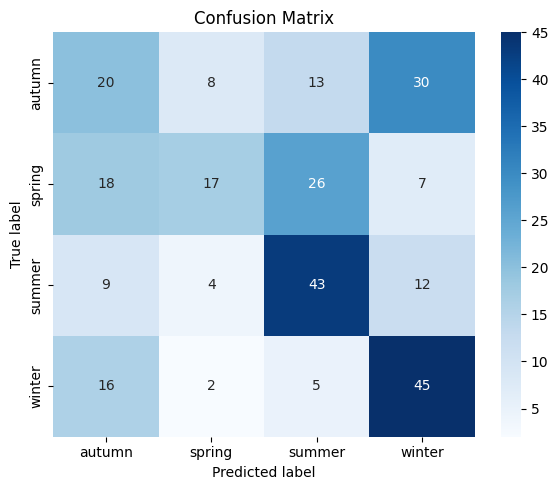

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
labels = list(label_map.keys())

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

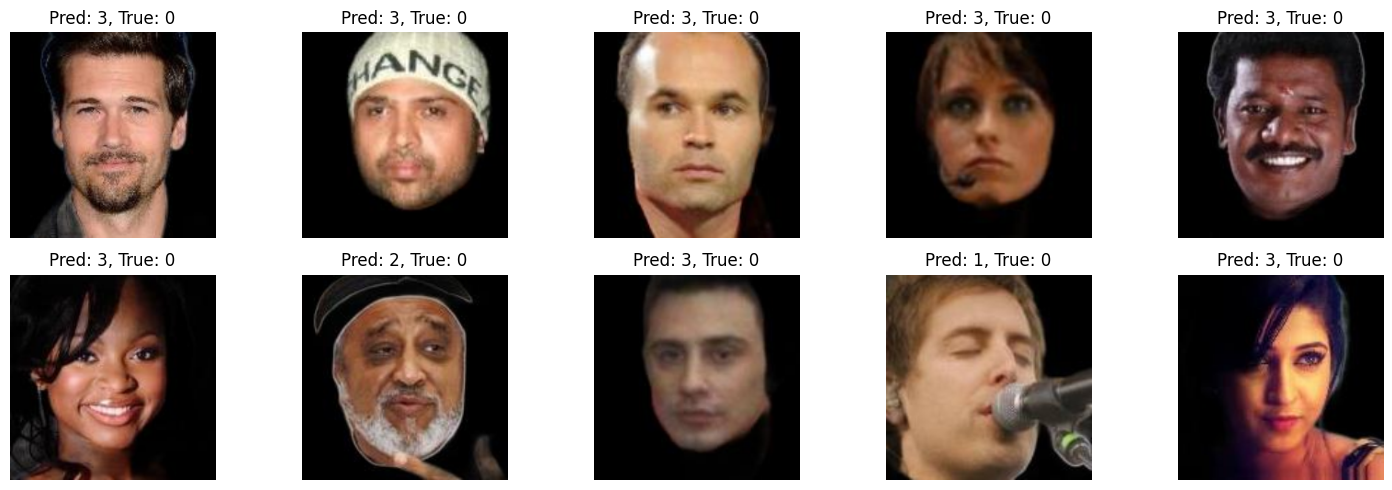

In [23]:
model.eval()
wrong_images = []
wrong_preds = []
wrong_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        wrong_mask = predicted != labels
        if wrong_mask.any():
            wrong_images.append(images[wrong_mask].cpu())
            wrong_preds.extend(predicted[wrong_mask].cpu().tolist())
            wrong_labels.extend(labels[wrong_mask].cpu().tolist())
if wrong_images:
    wrong_images = torch.cat(wrong_images)

    num_display = min(10, len(wrong_images))
    plt.figure(figsize=(15, 5))
    for i in range(num_display):
        img = wrong_images[i+30].permute(1, 2, 0).numpy()
        plt.subplot(2, 5, i+1)
        plt.imshow(img)
        plt.title(f"Pred: {wrong_preds[30+i]}, True: {wrong_labels[i+30]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()
else:
    print("Error.")
